In [36]:
%config InlineBackend.figure_format = "retina"
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
from astroquery.vizier import Vizier
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import time
import numpy.random as random
import emcee
import corner
import random
import scipy.integrate as integrate
from scipy import interpolate
from scipy import optimize
import math as math
from astroquery.mast import Catalogs
from astroquery.gaia import Gaia
import astropy.units as u
from astropy.coordinates import SkyCoord
import multiprocessing
import os
from multiprocessing import Pool
os.environ["OMP_NUM_THREADS"] = "1"
from multiprocessing import cpu_count
plt.rcParams['lines.linewidth']   =3
plt.rcParams['axes.linewidth']    = 2
plt.rcParams['xtick.major.width'] =2
plt.rcParams['ytick.major.width'] =2
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.labelweight']='semibold'
plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.weight'] = 'semibold'
plt.rcParams['axes.titleweight']='semibold'
plt.rcParams['axes.titlesize']=9
import glob
import warnings
warnings.filterwarnings('ignore')



In [37]:
import extinction

In [38]:
## first we need to read in the blob of models. 
files = glob.glob('young_models/*.dat')
df1 = pd.read_csv(files[0],delim_whitespace=True,comment='#')
df2 = pd.read_csv(files[1],delim_whitespace=True,comment='#')
df3 = pd.read_csv(files[2],delim_whitespace=True,comment='#')
df4 = pd.read_csv(files[3],delim_whitespace=True,comment='#')

result = pd.concat([df1, df2], axis=1, join='inner')
print(np.shape(result),np.shape(df1),np.shape(df2))
display(result)

(63276, 73) (63276, 42) (63276, 31)


,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,...,Y,Xc,Xn,Xo,Cexcess,Z,mbolmag,Gmag,G_BPmag,G_RPmag
0,0.0152,0.01508,5.00000,0.090000,1.081690,0.090,-0.764,3.4511,2.913,0,...,0.2755,0.002746,0.000741,0.006719,-1.0,0.01527,6.679,8.388,10.462,7.025
1,0.0152,0.01508,5.00000,0.100000,1.171106,0.100,-0.688,3.4553,2.899,0,...,0.2755,0.002746,0.000741,0.006719,-1.0,0.01527,6.491,8.175,10.223,6.818
2,0.0152,0.01508,5.00000,0.106772,1.225309,0.107,-0.644,3.4585,2.896,0,...,0.2755,0.002746,0.000741,0.006719,-1.0,0.01527,6.380,8.043,10.071,6.692
3,0.0152,0.01508,5.00000,0.123361,1.341069,0.123,-0.542,3.4660,2.887,0,...,0.2755,0.002746,0.000741,0.006719,-1.0,0.01527,6.124,7.745,9.730,6.405
4,0.0152,0.01508,5.00000,0.136437,1.418912,0.136,-0.471,3.4727,2.887,0,...,0.2755,0.002746,0.000741,0.006719,-1.0,0.01527,5.947,7.531,9.480,6.201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63271,0.0152,0.01508,7.30103,11.688676,2.627349,11.690,4.781,3.5412,-0.158,7,...,0.3012,0.001711,0.002598,0.005888,-1.0,0.01537,-7.183,-5.991,-4.398,-7.191
63272,0.0152,0.01508,7.30103,11.690249,2.627350,11.691,4.811,3.5378,-0.202,7,...,0.3014,0.001707,0.002605,0.005884,-1.0,0.01536,-7.258,-5.994,-4.308,-7.218
63273,0.0152,0.01508,7.30103,11.693567,2.627353,11.695,4.857,3.5326,-0.269,7,...,0.3026,0.001700,0.002627,0.005868,-1.0,0.01535,-7.373,-5.994,-4.157,-7.255
63274,0.0152,0.01508,7.30103,11.704233,2.627361,11.705,4.907,3.5275,-0.338,7,...,0.3145,0.001668,0.002767,0.005755,-1.0,0.01533,-7.497,-5.994,-3.998,-7.289


In [39]:
result = df1.combine_first(df2)
result = result.combine_first(df3)
result = result.combine_first(df4)

# l = np.squeeze(np.where((result['Mass']<0.8) & (result['Mass']>0.2)))
# print(np.shape(l))
# df = result.iloc[l]

models = result

In [40]:
l = np.where(models['Mass']<1.5)
models = models.iloc[l]

In [128]:
models['Mass'][50:100]

50     1.450
253    0.090
254    0.101
255    0.114
256    0.121
257    0.131
258    0.142
259    0.153
260    0.174
261    0.189
262    0.224
263    0.249
264    0.250
265    0.281
266    0.300
267    0.350
268    0.400
269    0.450
270    0.487
271    0.500
272    0.507
273    0.545
274    0.550
275    0.553
276    0.596
277    0.600
278    0.636
279    0.650
280    0.681
281    0.700
282    0.718
283    0.750
284    0.753
285    0.781
286    0.800
287    0.804
288    0.844
289    0.850
290    0.872
291    0.899
292    0.925
293    0.950
294    0.968
295    1.000
296    1.040
297    1.050
298    1.077
299    1.099
300    1.110
301    1.149
Name: Mass, dtype: float64

In [41]:
for i in models.columns:
    print(i)

C_O
Cexcess
G_BPmag
G_RPmag
Gmag
Hmag
IRAC_3.6mag
IRAC_4.5mag
IRAC_5.8mag
IRAC_8.0mag
Jmag
Ksmag
MH
MIPS_160mag
MIPS_24mag
MIPS_70mag
Mass
McoreTP
Mini
Mloss
W1mag
W2mag
W3mag
W4mag
X
Xc
Xn
Xo
Y
Z
Zini
gP1mag
gmag
iP1mag
imag
int_IMF
label
logAge
logL
logTe
logg
mbolmag
period0
period1
period2
period3
period4
pmode
rP1mag
rmag
tau1m
umag
wP1mag
yP1mag
zP1mag
zmag


In [42]:
diff = np.abs(models['logAge'].values-np.log10(age*1e6))
l = np.where( diff == np.min(diff))
grid = models.iloc[l]
grid['Mass']

53355    0.090
53356    0.099
53357    0.100
53358    0.120
53359    0.140
         ...  
53422    1.375
53423    1.398
53424    1.400
53425    1.415
53426    1.450
Name: Mass, Length: 72, dtype: float64

In [65]:
age = 17
mass = 1

def interpolate_mags(age,mass,df,returnparams=False,kind='linear'): ## age in myr
    diff = np.abs(df['logAge'].values-np.log10(age*1e6))
    l = np.where( diff == np.min(diff))
    grid = df.iloc[l]
    fj = interpolate.interp1d(grid['Mass'],grid['Jmag'],fill_value='extrapolate',kind=kind)
    fh = interpolate.interp1d(grid['Mass'],grid['Hmag'],fill_value='extrapolate',kind=kind)
    fk = interpolate.interp1d(grid['Mass'],grid['Ksmag'],fill_value='extrapolate',kind=kind)

    frp = interpolate.interp1d(grid['Mass'],grid['G_RPmag'],fill_value='extrapolate',kind=kind)
    fbp = interpolate.interp1d(grid['Mass'],grid['G_BPmag'],fill_value='extrapolate',kind=kind)
    fgg = interpolate.interp1d(grid['Mass'],grid['Gmag'],fill_value='extrapolate',kind=kind)
    
    fsg = interpolate.interp1d(grid['Mass'],grid['gmag'],fill_value='extrapolate',kind=kind)
    fsr = interpolate.interp1d(grid['Mass'],grid['rmag'],fill_value='extrapolate',kind=kind)
    fsi = interpolate.interp1d(grid['Mass'],grid['imag'],fill_value='extrapolate',kind=kind)
#     fsz = interpolate.interp1d(grid['Mass'],grid['zmag'],fill_value="extrapolate",kind=kind)

    fw1 = interpolate.interp1d(grid['Mass'],grid['W1mag'],fill_value="extrapolate",kind=kind)
    fw2 = interpolate.interp1d(grid['Mass'],grid['W2mag'],fill_value="extrapolate",kind=kind)

    fs1 = interpolate.interp1d(grid['Mass'],grid['IRAC_3.6mag'],fill_value="extrapolate",kind=kind)
    fs2 = interpolate.interp1d(grid['Mass'],grid['IRAC_4.5mag'],fill_value="extrapolate",kind=kind)
    fs3 = interpolate.interp1d(grid['Mass'],grid['IRAC_5.8mag'],fill_value="extrapolate",kind=kind)
    fs4 = interpolate.interp1d(grid['Mass'],grid['IRAC_8.0mag'],fill_value="extrapolate",kind=kind)

    fpg = interpolate.interp1d(grid['Mass'],grid['gP1mag'],fill_value="extrapolate",kind=kind)
    fpr = interpolate.interp1d(grid['Mass'],grid['rP1mag'],fill_value="extrapolate",kind=kind)
    fpy = interpolate.interp1d(grid['Mass'],grid['yP1mag'],fill_value="extrapolate",kind=kind)
    
    
    fteff = interpolate.interp1d(grid['Mass'],grid['logTe'],fill_value="extrapolate",kind=kind)
    flogg = interpolate.interp1d(grid['Mass'],grid['logg'],fill_value="extrapolate",kind=kind)
    interpolator = [fbp,frp,fgg,fj,fh,fk,fsg,fsr,fsi,fw1,fw2,fs1,fs2,fs3,fs4,fpg,fpr,fpy]
    mags = []
    for i in interpolator:
        mag = i(mass)
        mags.append(mag)
    if returnparams == True:
        logteff = fteff(mass)
        logg = flogg(mass)
        return np.array(mags),logteff,logg
    return np.array(mags)

result1 = interpolate_mags(age,mass,models,kind='linear')
result3 = interpolate_mags(age,mass,models,kind='cubic')
print(result1-result3)
print(result,np.shape(result1))

[ 8.8817842e-16  0.0000000e+00  0.0000000e+00  0.0000000e+00
  4.4408921e-16  4.4408921e-16  8.8817842e-16  0.0000000e+00
 -8.8817842e-16  4.4408921e-16  0.0000000e+00  0.0000000e+00
 -4.4408921e-16 -4.4408921e-16  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
[15.12666667 11.064      12.51988889  8.37088889  7.804       7.463
 15.70855556 14.29266667 11.97688889 10.549       7.157       6.88488889
  7.00088889  6.87688889  6.81588889  6.72088889 15.47866667 14.25766667
 10.077     ] (18,)


In [68]:
## write out the mags
mags =     np.array([15.5948,12.7382,13.9813,10.709,9.756,9.376,16.808,14.660,13.648,9.038,8.893,9.09,9.06,8.97,9.05,16.5592,14.5401,12.2263]-5.0*(np.log10(1000./6.2474)-1))
mag_errs = np.array([0.0390,  0.0242, 0.0318, 0.029,0.030,0.028,0.030, 0.030 ,0.200,0.022, 0.021,0.03,0.03,0.04,0.04,0.0022 ,0.0149 ,0.0215 ])
names =           [   'gbp',   'grp','gaiag','jmag','hmag','kmag','gp',  'rp', 'ip','w1' ,'w2'  ,'s1','s2','s3','s4',  'psg','psr'  ,'psy']
waves =    np.array([5041  ,7690    ,5850    ,12350,16620,21590  ,4723,6201  ,7672,33526,46028,35074,44365,56280,75890,4810 ,6155   ,9613])

print(mags)
## function that reddends the model magnitudes
redmag = extinction.fm07(waves,2.8)
print(redmag,np.shape(redmag),np.shape(mags),np.shape(waves))

[ 9.57329657  6.71669657  7.95979657  4.68749657  3.73449657  3.35449657
 10.78649657  8.63849657  7.62649657  3.01649657  2.87149657  3.06849657
  3.03849657  2.94849657  3.02849657 10.53769657  8.51859657  6.20479657]
[3.15637266 1.64464298 2.58371078 0.68739561 0.3990109  0.24550489
 3.40341522 2.36445157 1.65153245 0.10786329 0.06299965 0.09945424
 0.06677282 0.0466988  0.03137932 3.33473714 2.39206254 1.09159898] (18,) (18,) (18,)


In [49]:
## mags for the companion
mags_comp = np.array([20.643425, 15.832121, 17.444998,12.726, 11.807,11.288])-5.0*(np.log10(1000./6.2474)-1)
mag_comp_errs = np.array([0.125398,0.007736,0.003135,0.034,0.041,0.028])
names_comp =  [   'gbp',   'grp','gaiag','jmag','hmag','kmag']
waves_comp = np.array([5041  ,7690    ,5850    ,12350,16620,21590])
redmag = extinction.fm07(waves_comp,2.8)

result = interpolate_mags(age,0.08,models,kind='linear')
redmag = extinction.fm07(waves,2.8)
arr = result[0:len(names_comp)]
for i,j,k in zip(arr,mags_comp,names_comp):
    print(k,i,j)

gbp 15.126666666666667 14.621921566252727
grp 11.064 9.810617566252727
gaiag 12.519888888888884 11.423494566252725
jmag 8.370888888888889 6.704496566252728
hmag 7.8039999999999985 5.785496566252728
kmag 7.462999999999998 5.266496566252727


100%|█████████████████████████████████████████████████████| 20000/20000 [45:04<00:00,  7.40it/s]


MCMC done
3848.981278058066 3.966282839950459 1.7221925218248944
7.269072194167276 gbp 9.982828433757026 9.573296566252726 1.9231980694044175
5.334649707195106 grp 6.748665296892537 6.716696566252728 0.15170077626891926
6.3032035539691105 gaiag 8.524601975022295 7.959796566252726 2.6835009224271684
4.0261396470217115 jmag 4.6171421444775484 4.687496566252727 -0.33289614042487037
3.2659005936718644 hmag 3.6089584128327483 3.7344965662527274 -0.5936171596317055
3.09842248697217 kmag 3.309500360308287 3.3544965662527266 -0.213044610574279
7.780191720842199 gp 10.706347882629283 10.786496566252726 -0.3789894356785789
6.539952667492351 rp 8.572838485907376 8.638496566252726 -0.3104694636624674
5.762247340569722 ip 7.182186292827706 7.626496566252727 -1.5346265732426587
5.351095860421099 zp 6.147763176048031 6.550496566252726 -1.9043569199426464
3.0259443802724757 w1 3.118682055720024 3.0164965662527274 0.48545524250379457
3.031227220222935 w2 3.0853924676761237 2.871496566252728 1.016654223

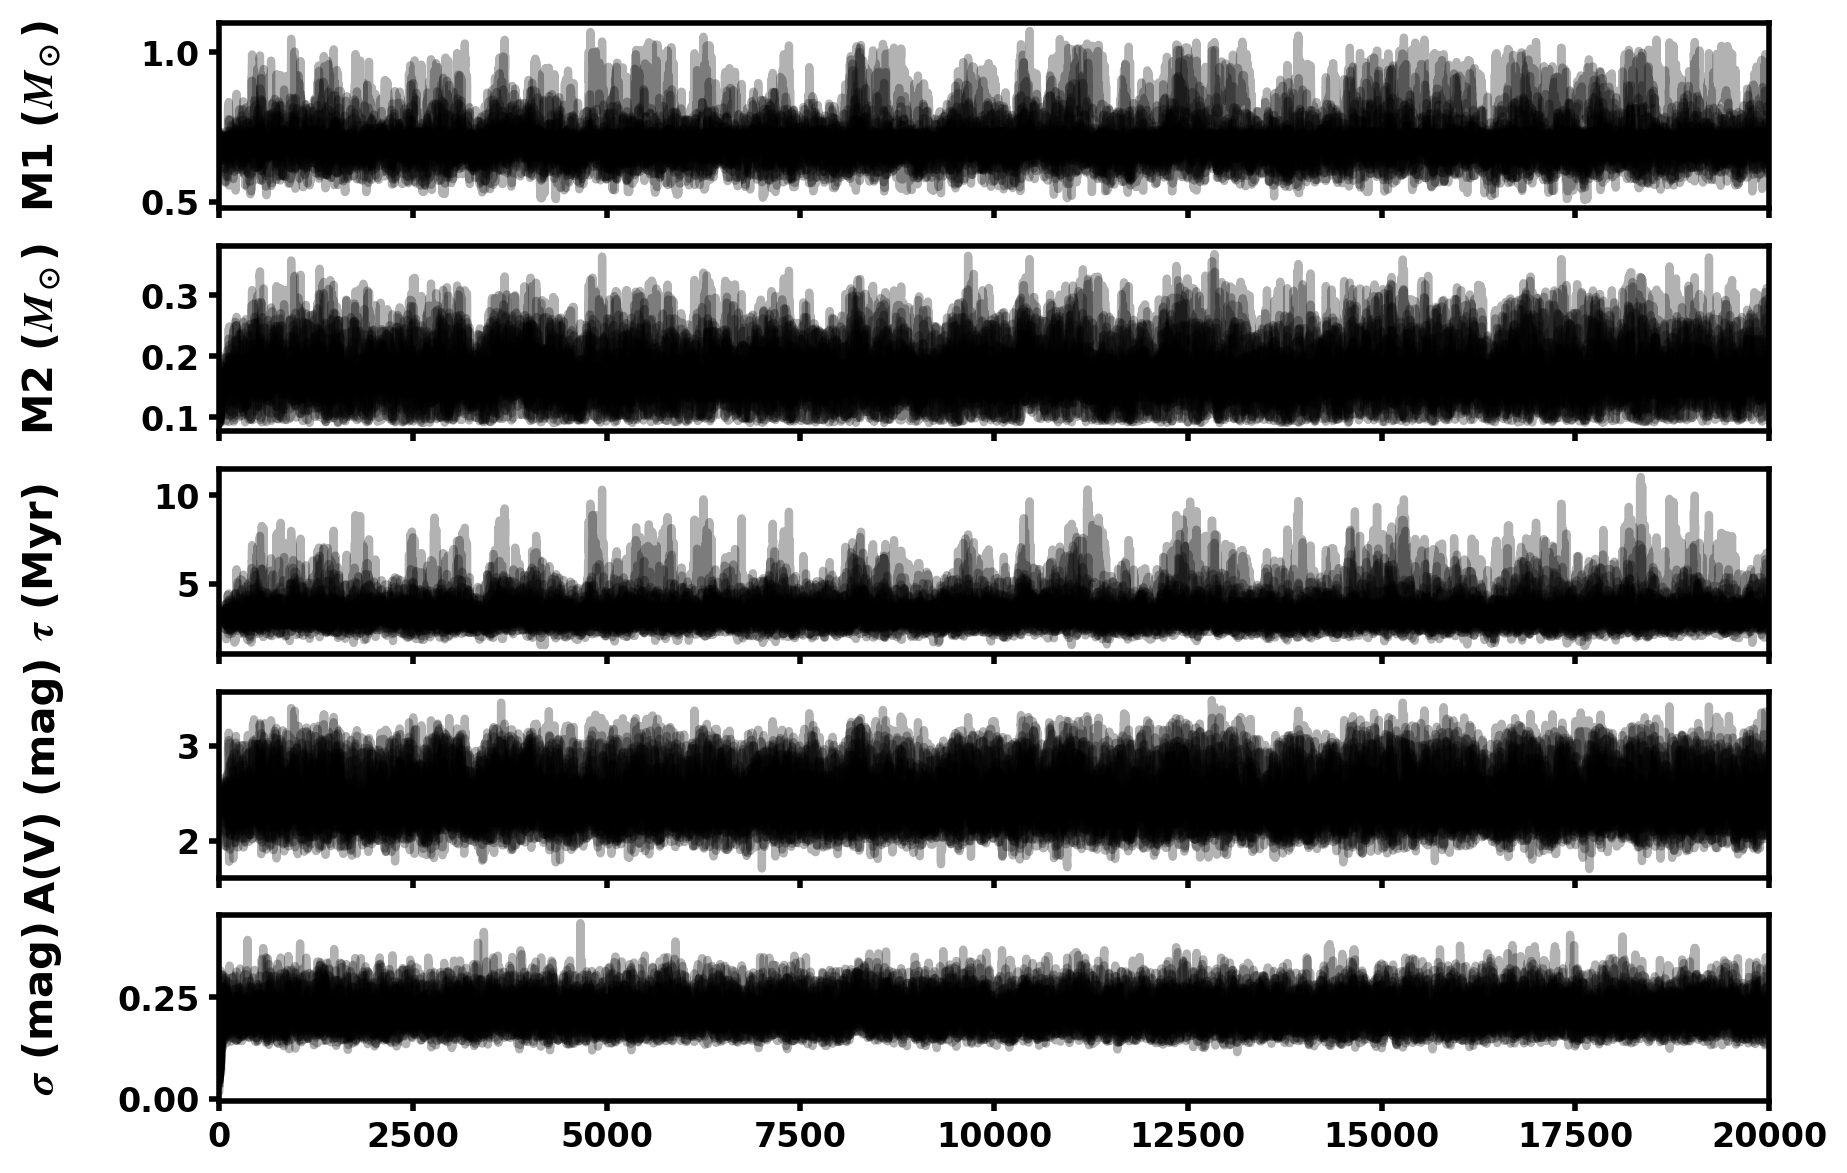

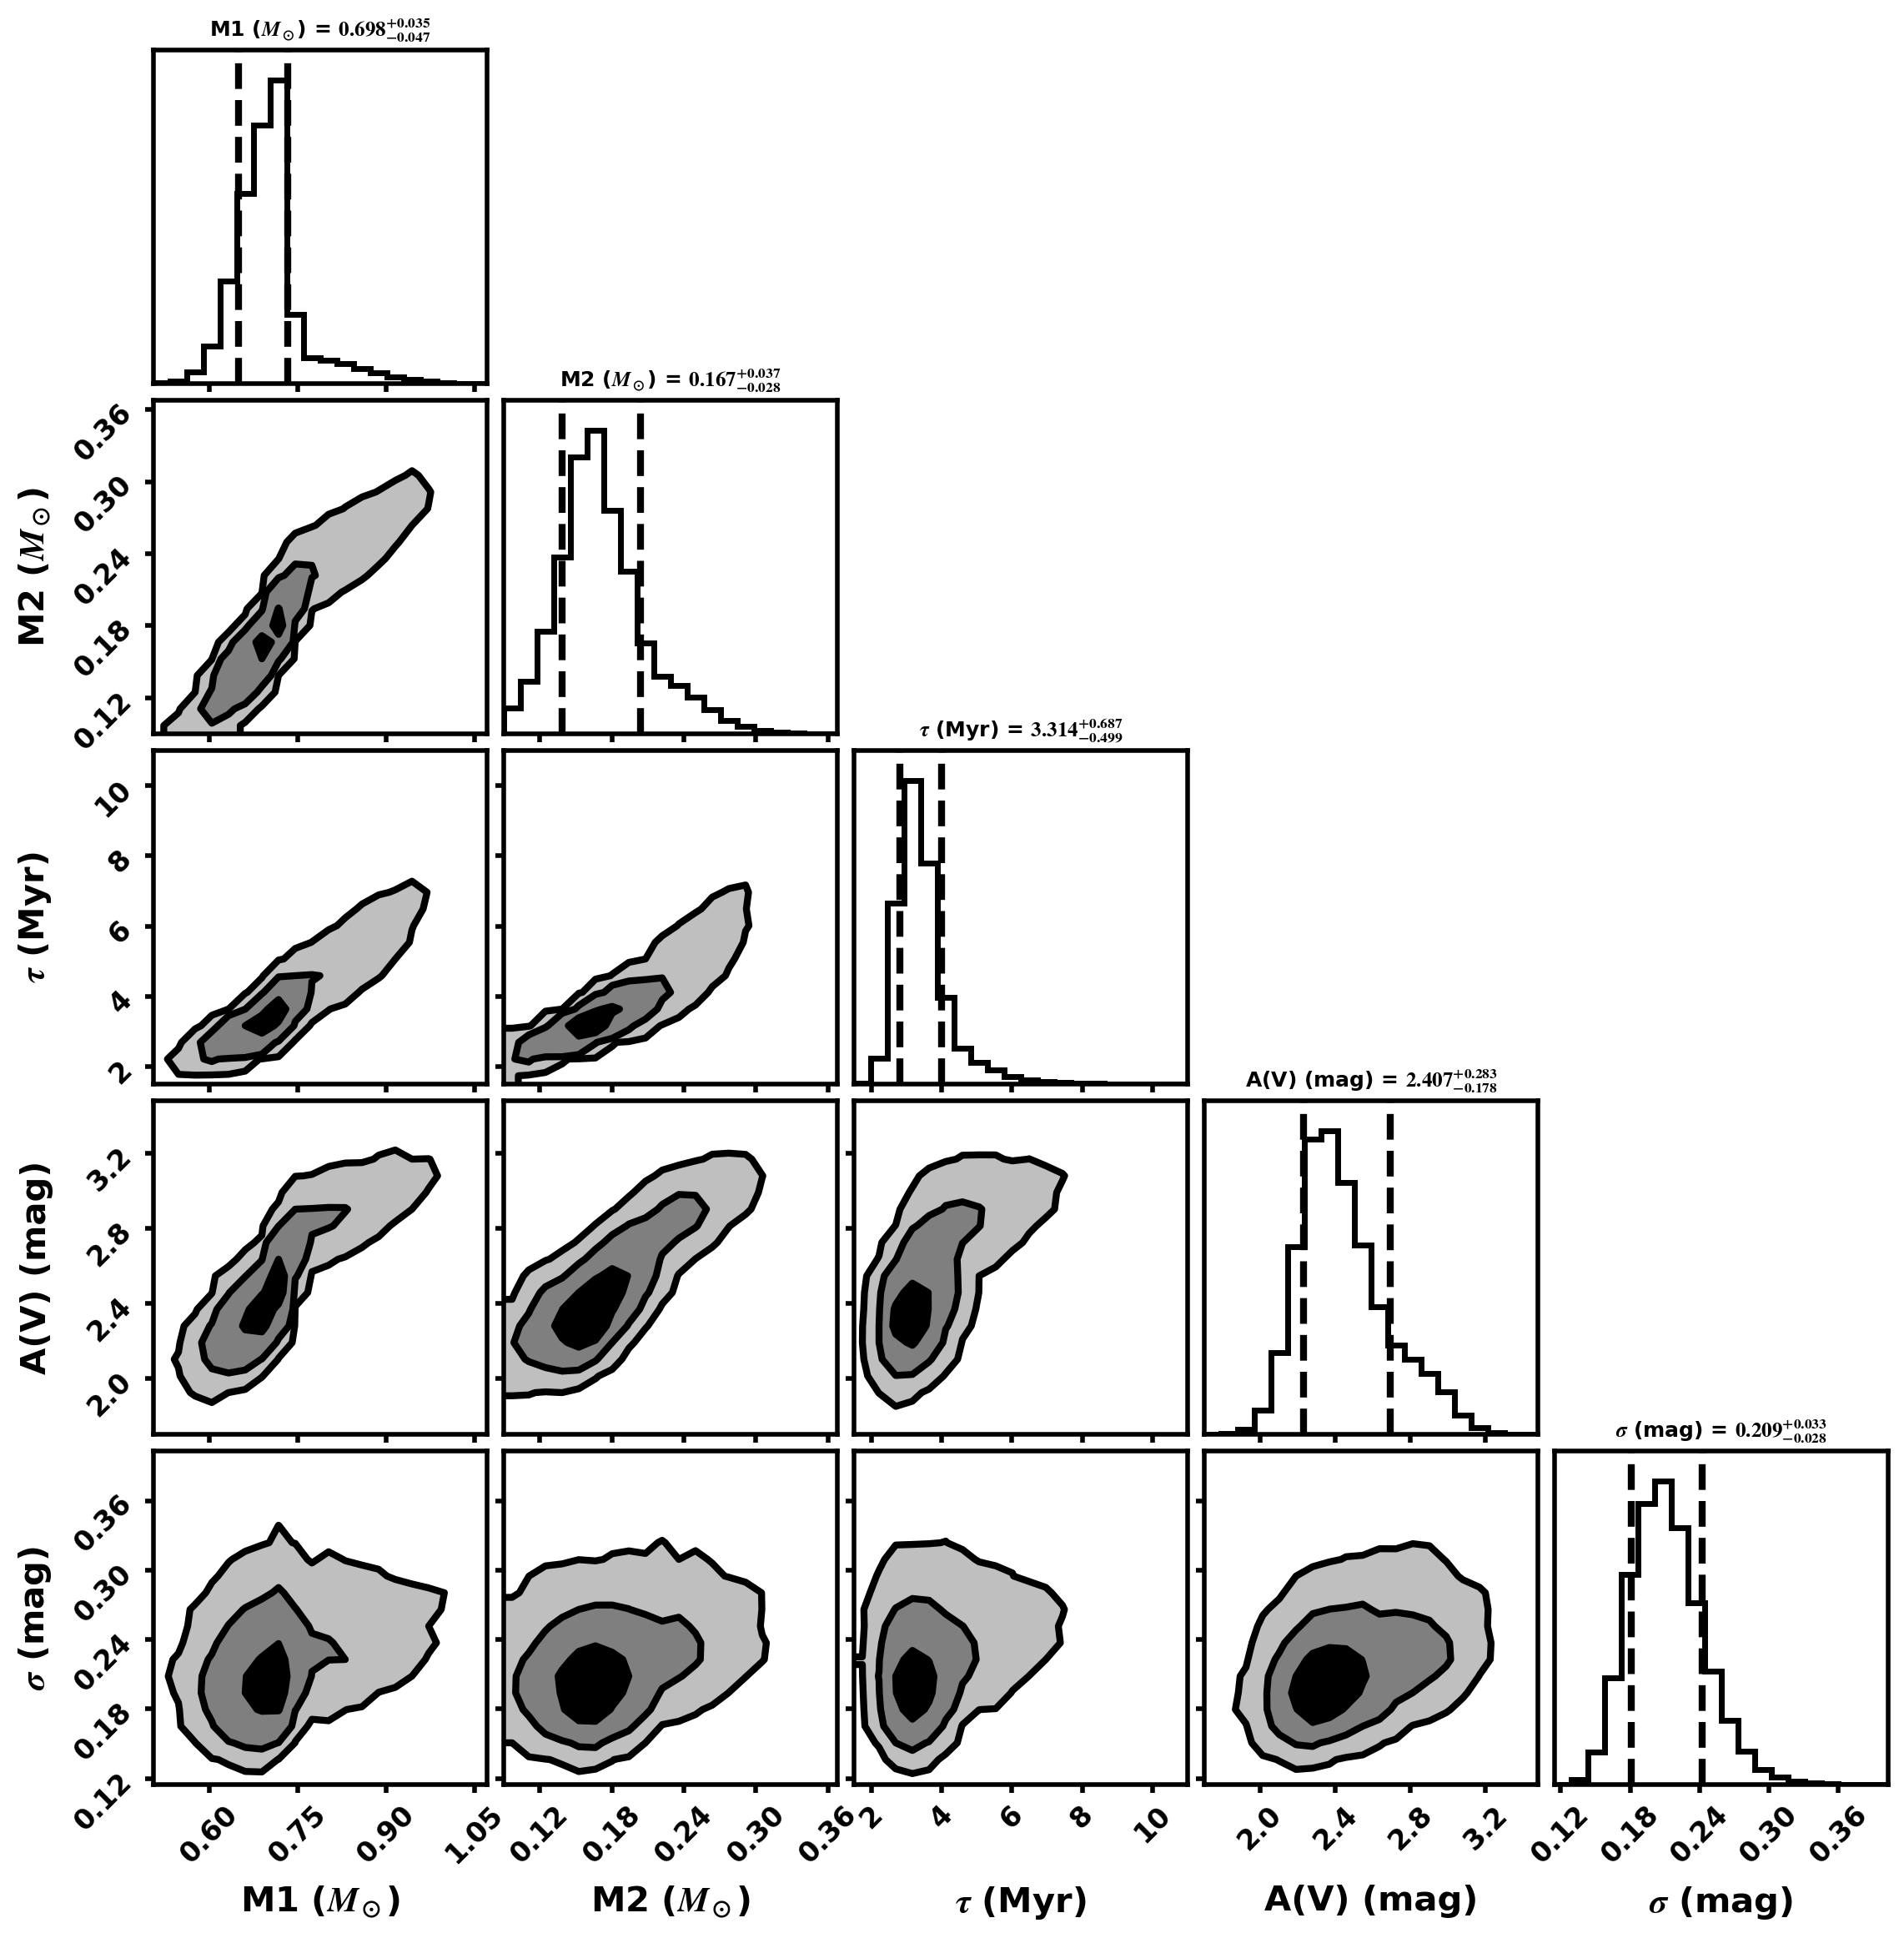

In [50]:
# ## fitting primary and companion
# def ln_likelihood(theta, mags, mag_errs, waves, mags_comp, mag_comp_errs, waves_comp, models):
#     massp,massc,age,av, missing_unc = theta
#     ## get the grid photometry:
#     model_mags = interpolate_mags(age,massp,models,kind='linear')
#     ##extinction
#     redmag = extinction.fm07(waves,av)
#     modelp = model_mags+redmag
#     sigma2 = mag_errs**2 + missing_unc**2
#     p1 = -0.5*np.sum((mags-modelp)**2/sigma2 + np.log(2*np.pi*sigma2))
    
#     model_mags2 = interpolate_mags(age,massc,models,kind='linear')
#     redmag = extinction.fm07(waves_comp,av)
#     modelc = model_mags2[0:len(mags_comp)]+redmag
#     sigma2 = mag_comp_errs**2 + missing_unc**2
#     p2 = -0.5*np.sum((mags_comp-modelc)**2/sigma2 + np.log(2*np.pi*sigma2))
    
#     return p1+p2

# def ln_prior(theta):
#     massp,massc,age,av, missing_unc = theta
#     if (massp < 0.1) or (massc < 0.09) or (age < 0.1) or (age > 19) or (missing_unc<0):        
#         return -np.inf
#     else:
#         model1 = 3.1*0.874
#         sigma12 = (3.1*0.069)**2
#         p1 = -0.5*np.sum((av-model1)**2/sigma12 + np.log(2*np.pi*sigma12))
# #         model2 = 3
# #         sigma22 = 3**2
# #         p2 = -0.5*np.sum((age-model2)**2/sigma22 + np.log(2*np.pi*sigma22))
#         p2 = 0
#         model3 = 0.0
#         sigma32 = 0.1**2
#         p3 = -0.5*np.sum((missing_unc-model3)**2/sigma32 + np.log(2*np.pi*sigma32))
#         return p1+p2+p3

# def ln_probability(theta, mags,mag_errs,waves, mags_comp, mag_comp_errs, waves_comp, models):
#     lp = ln_prior(theta)
#     if not np.isfinite(lp):
#         return -np.inf
#     return lp + ln_likelihood(theta, mags,mag_errs,waves,mags_comp, mag_comp_errs, waves_comp, models)


# initial_guesses = np.array([0.7, 0.1, 3.3, 2.4, 0.05]) 
# ndim = np.size(initial_guesses)
# randomizer = [0.01, 0.01, 0.01, 0.01,0.01]
# nwalkers = ndim*5
# pos0 = []

# nsteps = 20000
# counter = 0
# while len(pos0) < nwalkers:
#     counter+=1
#     if counter > 5000:
#         print('failed to initialize walkers, check the initial conditions and/or input data')
#         break 
#     trial = initial_guesses + randomizer * np.random.randn(ndim)
#     lp = ln_probability(trial, mags,mag_errs,waves,mags_comp,mag_comp_errs,waves_comp, models)
#     if np.isfinite(lp):
#         pos0.append(trial)
        
        
# sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_probability, args=(mags,mag_errs,waves,mags_comp,mag_comp_errs,waves_comp,models), threads=8)
# sampler.run_mcmc(pos0, nsteps, progress=True)

# print('MCMC done')


# burn = sampler.iteration//2
# samples = sampler.get_chain()
# fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
# labels = [r'M1 ($M_\odot$)',r'M2 ($M_\odot$)',r'$\tau$ (Myr)',r'A(V) (mag)',r'$\sigma$ (mag)']
# for i in range(ndim):
#      ax = axes[i]
#      ax.plot(samples[:, :, i], "k", alpha=0.3)
#      ax.set_xlim(0, len(samples))
#      ax.set_ylabel(labels[i])
#      ax.yaxis.set_label_coords(-0.1, 0.5)
        
# fig.set_rasterized(True)
# fig.show()

# flat_samples = sampler.get_chain(discard=burn, thin=1, flat=True)

# fig = corner.corner( 
#     flat_samples,show_titles=True,labels=labels,quantiles=(0.16, 0.84),rng=0.998,
#     fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 9},title_fmt='.3f',
#     hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))]
# );
# fig.savefig('Corner_bothstar.pdf',dpi=400)

# ## get the best-fit model
# probs = sampler.get_log_prob(discard=burn, thin=1, flat=True)
# l = np.where(probs == np.max(probs))[0]
# params = np.array(flat_samples[l,:])
# # for i in range(ndim):
# #     params[i] = np.percentile(flat_samples[:, i],[50])

# massp,massc,age,av,logf = params
# model_mags,teff,logg = interpolate_mags(age,massp,models,returnparams=True,kind='linear')
# redmag = extinction.fm07(waves,av)
# prediction = model_mags+redmag
# r = np.sqrt(6.6743e-8*mass*1.989e33/10**logg)/6.955e10
# print(10**teff,logg,r)
# for i,j,k,l,m in zip(prediction,mags,names,mag_errs,model_mags):
#     print(m,k,i,j,(i-j)/(np.sqrt(l**2+logf**2)))
    
    
# elements = 500

# rads = []
# teffs = []
# for i in range(elements):
#     index = random.randrange(0, np.size(flat_samples[:,0])-1)
#     massp,massc,age,av,missing_unc = flat_samples[index,:]
    
#     model_mags,teff,logg = interpolate_mags(age,massp,models,returnparams=True,kind='linear')
#     redmag = extinction.fm07(waves,av)
#     prediction = model_mags+redmag
#     r = np.sqrt(6.6743e-8*mass*1.989e33/10**logg)/6.955e10
#     teff = 10**teff
#     teffs.append(teff)
#     rads.append(r)
    
# print(np.median(teffs),np.std(teffs),np.median(rads),np.std(rads))

array([40866])

In [156]:
## just fitting the primary:
def ln_likelihood(theta, mags, mag_errs, waves, models):
    mass,age,av, missing_unc = theta
    ## get the grid photometry:
    try:
        model_mags = interpolate_mags(age,mass,models,kind='cubic')
    except:
        return -np.inf
    ##extinction
    redmag = extinction.fm07(waves,av)
    model = model_mags+redmag
    
    sigma2 = mag_errs**2 + missing_unc**2
    return -0.5*np.sum((mags-model)**2/sigma2 + np.log(2*np.pi*sigma2))

def ln_prior(theta):
    mass,age,av, missing_unc = theta
    if (mass < 0.1) or (mass > 0.85) or (age < 0.1) or (age > 19) or (missing_unc<0):        
        return -np.inf
    else:
        model1 = 2.65
        sigma12 = (0.20)**2
        p1 = -0.5*np.sum((av-model1)**2/sigma12 + np.log(2*np.pi*sigma12))
#         model2 = 3
#         sigma22 = 3**2
#         p2 = -0.5*np.sum((age-model2)**2/sigma22 + np.log(2*np.pi*sigma22))
        p2 = 0
        model3 = 0.0
        sigma32 = 0.1**2
        p3 = -0.5*np.sum((missing_unc-model3)**2/sigma32 + np.log(2*np.pi*sigma32))
        return p1+p2+p3

def ln_probability(theta, mags,mag_errs,waves,models):
    lp = ln_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_likelihood(theta, mags,mag_errs,waves,models)

initial_guesses = np.array([0.703, 3.3, 2.45, 0.10]) 
model_mags = interpolate_mags(initial_guesses[1],initial_guesses[0],models,kind='cubic')
redmag = extinction.fm07(waves,initial_guesses[2])
prediction = model_mags+redmag
for i,j,k,l in zip(prediction,mags,names,mag_errs):
    print(k,i,j,(i-j)/l)
    
    

ndim = np.size(initial_guesses)
randomizer = [0.01, 0.01, 0.01,0.01]
nwalkers = ndim*5
pos0 = []

nsteps = 10000
counter = 0
while len(pos0) < nwalkers:
    counter+=1
    if counter > 5000:
        print('failed to initialize walkers, check the initial conditions and/or input data')
        break 
    trial = initial_guesses + randomizer * np.random.randn(ndim)
    lp = ln_probability(trial, mags,mag_errs,waves,models)
    if np.isfinite(lp):
        pos0.append(trial)


sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_probability, args=(mags,mag_errs,waves,models), threads=8)
sampler.run_mcmc(pos0, nsteps, progress=True)

print('MCMC done')



gbp 9.97786079467113 9.573296566252726 10.37344175431807
grp 6.743343605300691 6.716696566252728 1.1011173160315177
gaiag 8.526205274649008 7.959796566252726 17.81159460365667
jmag 4.611403890621575 4.687496566252727 -2.623885366591447
hmag 3.5990117487765088 3.7344965662527274 -4.516160582540622
kmag 3.2998804244467057 3.3544965662527266 -1.9505764930721758
gp 10.705076045134813 10.786496566252726 -2.714017370597096
rp 8.556641593391264 8.638496566252726 -2.7284990953820794
ip 7.174891844385018 7.626496566252727 -2.2580236093385464
w1 3.108912440219418 3.0164965662527274 4.200721543940477
w2 3.0800614635675028 2.871496566252728 9.931661776894043
s1 3.0697592921749077 3.068496566252727 0.04209086407268951
s2 3.077373436652411 3.0384965662527277 1.2958956799894377
s3 3.01779545178532 2.948496566252728 1.7324721383148
s4 2.946389309304736 3.028496566252728 -2.052681423699798
psg 10.470707948348828 10.537696566252727 -30.449371774499536
psr 8.575799637149961 8.518596566252729 3.8391322749

100%|█████████████████████████████████████████████████████| 10000/10000 [16:07<00:00, 10.34it/s]

MCMC done


3923.609954066905 3.9787710194715755 1.4309866436214007
7.0956787454875645 gbp 9.90163325020223 9.573296566252726 1.912425492046362
5.237854986340026 grp 6.69991092038666 6.716696566252728 -0.09935862503034619
6.18096259409984 gaiag 8.477831714246944 7.959796566252726 3.043774990336698
3.9783645034449893 jmag 4.58944596162508 4.687496566252727 -0.5778080252773589
3.2208012042167193 hmag 3.575514210126783 3.7344965662527274 -0.935917928699097
3.0625048845705543 kmag 3.2807540039618397 3.3544965662527266 -0.43499250314246235
7.604614510120792 gp 10.630185098917037 10.786496566252726 -0.9201945945803024
6.370130432645753 rp 8.472082345841361 8.638496566252726 -0.9796687901020682
5.659387734694538 ip 7.127568274045571 7.626496566252727 -1.9139348873341737
2.996127717620722 w1 3.0920161008080616 3.0164965662527274 0.44781796501788435
3.0180701887018553 w2 3.074075668439872 2.871496566252728 1.2021687250304525
2.969898016562917 s1 3.0583109161653956 3.068496566252727 -0.059962204388498905
3.

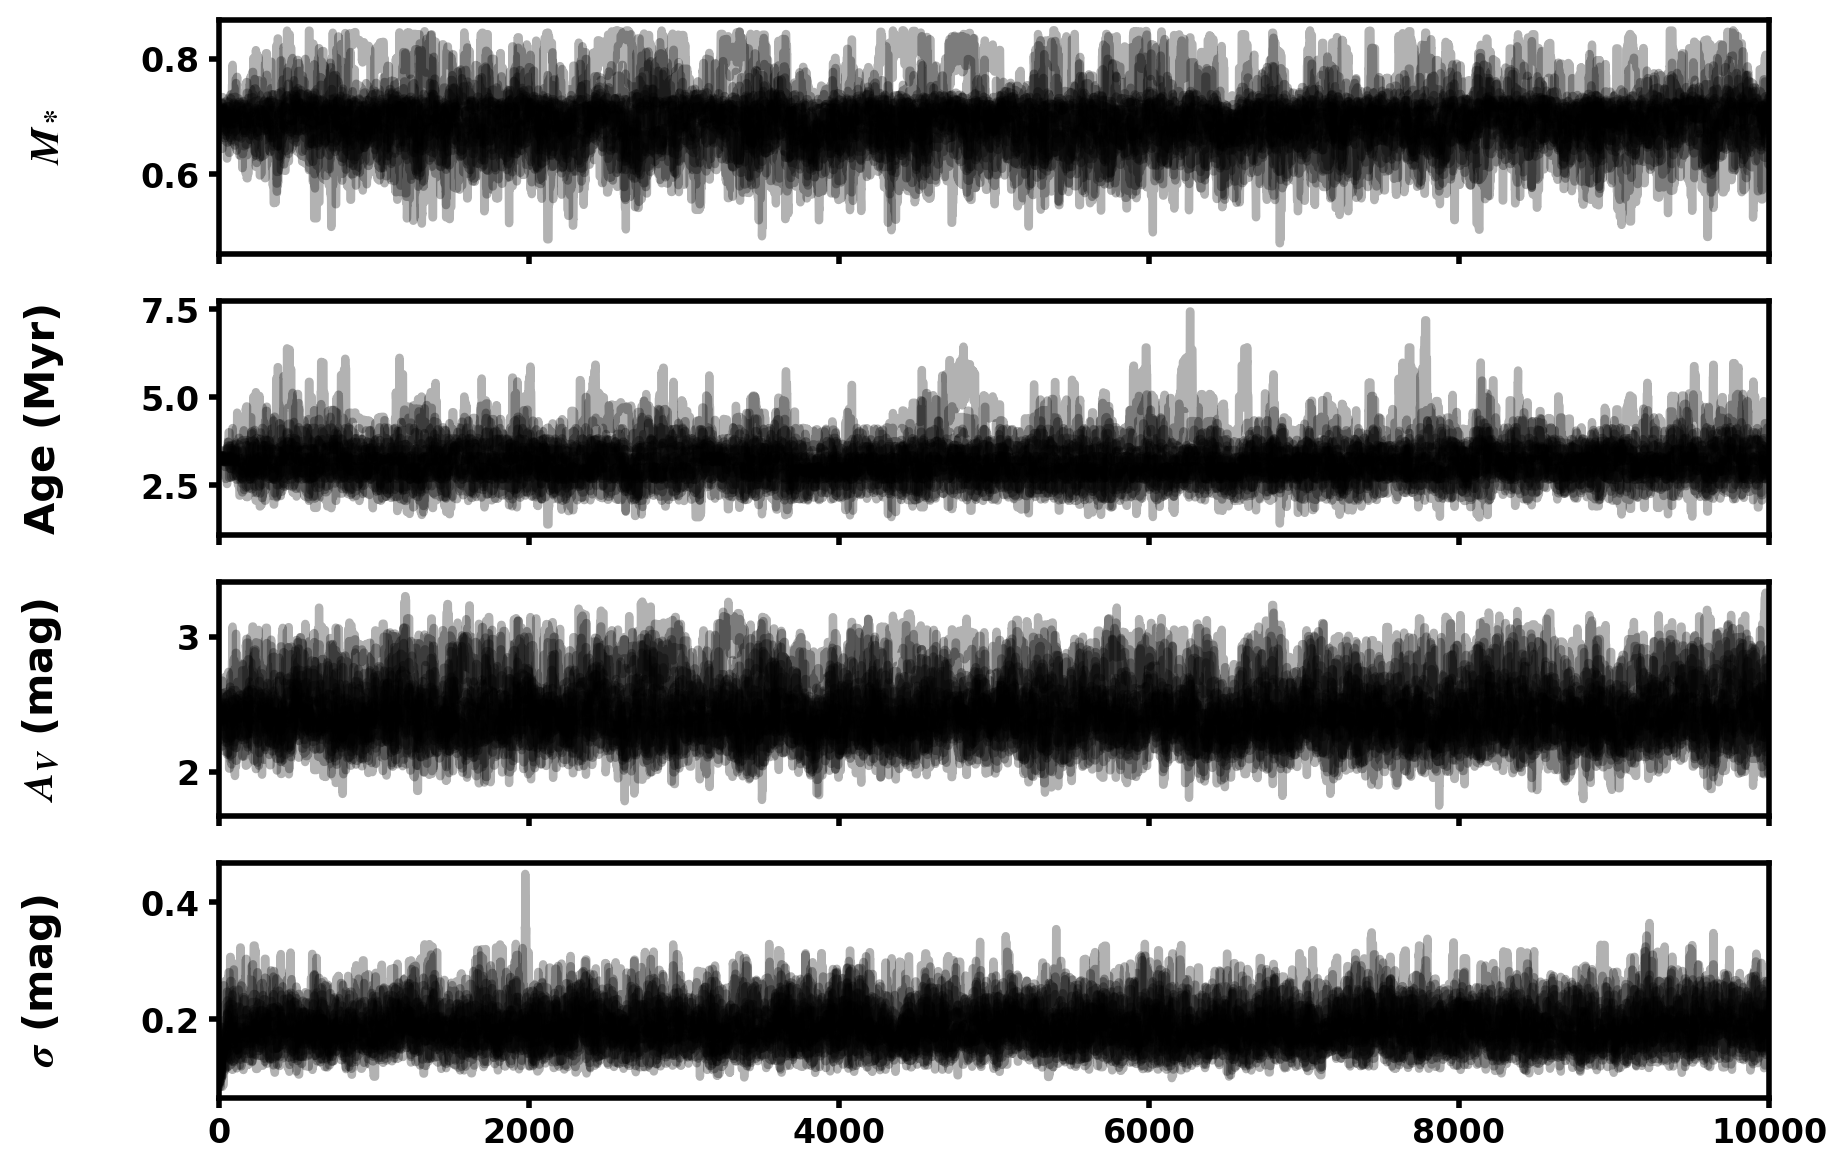

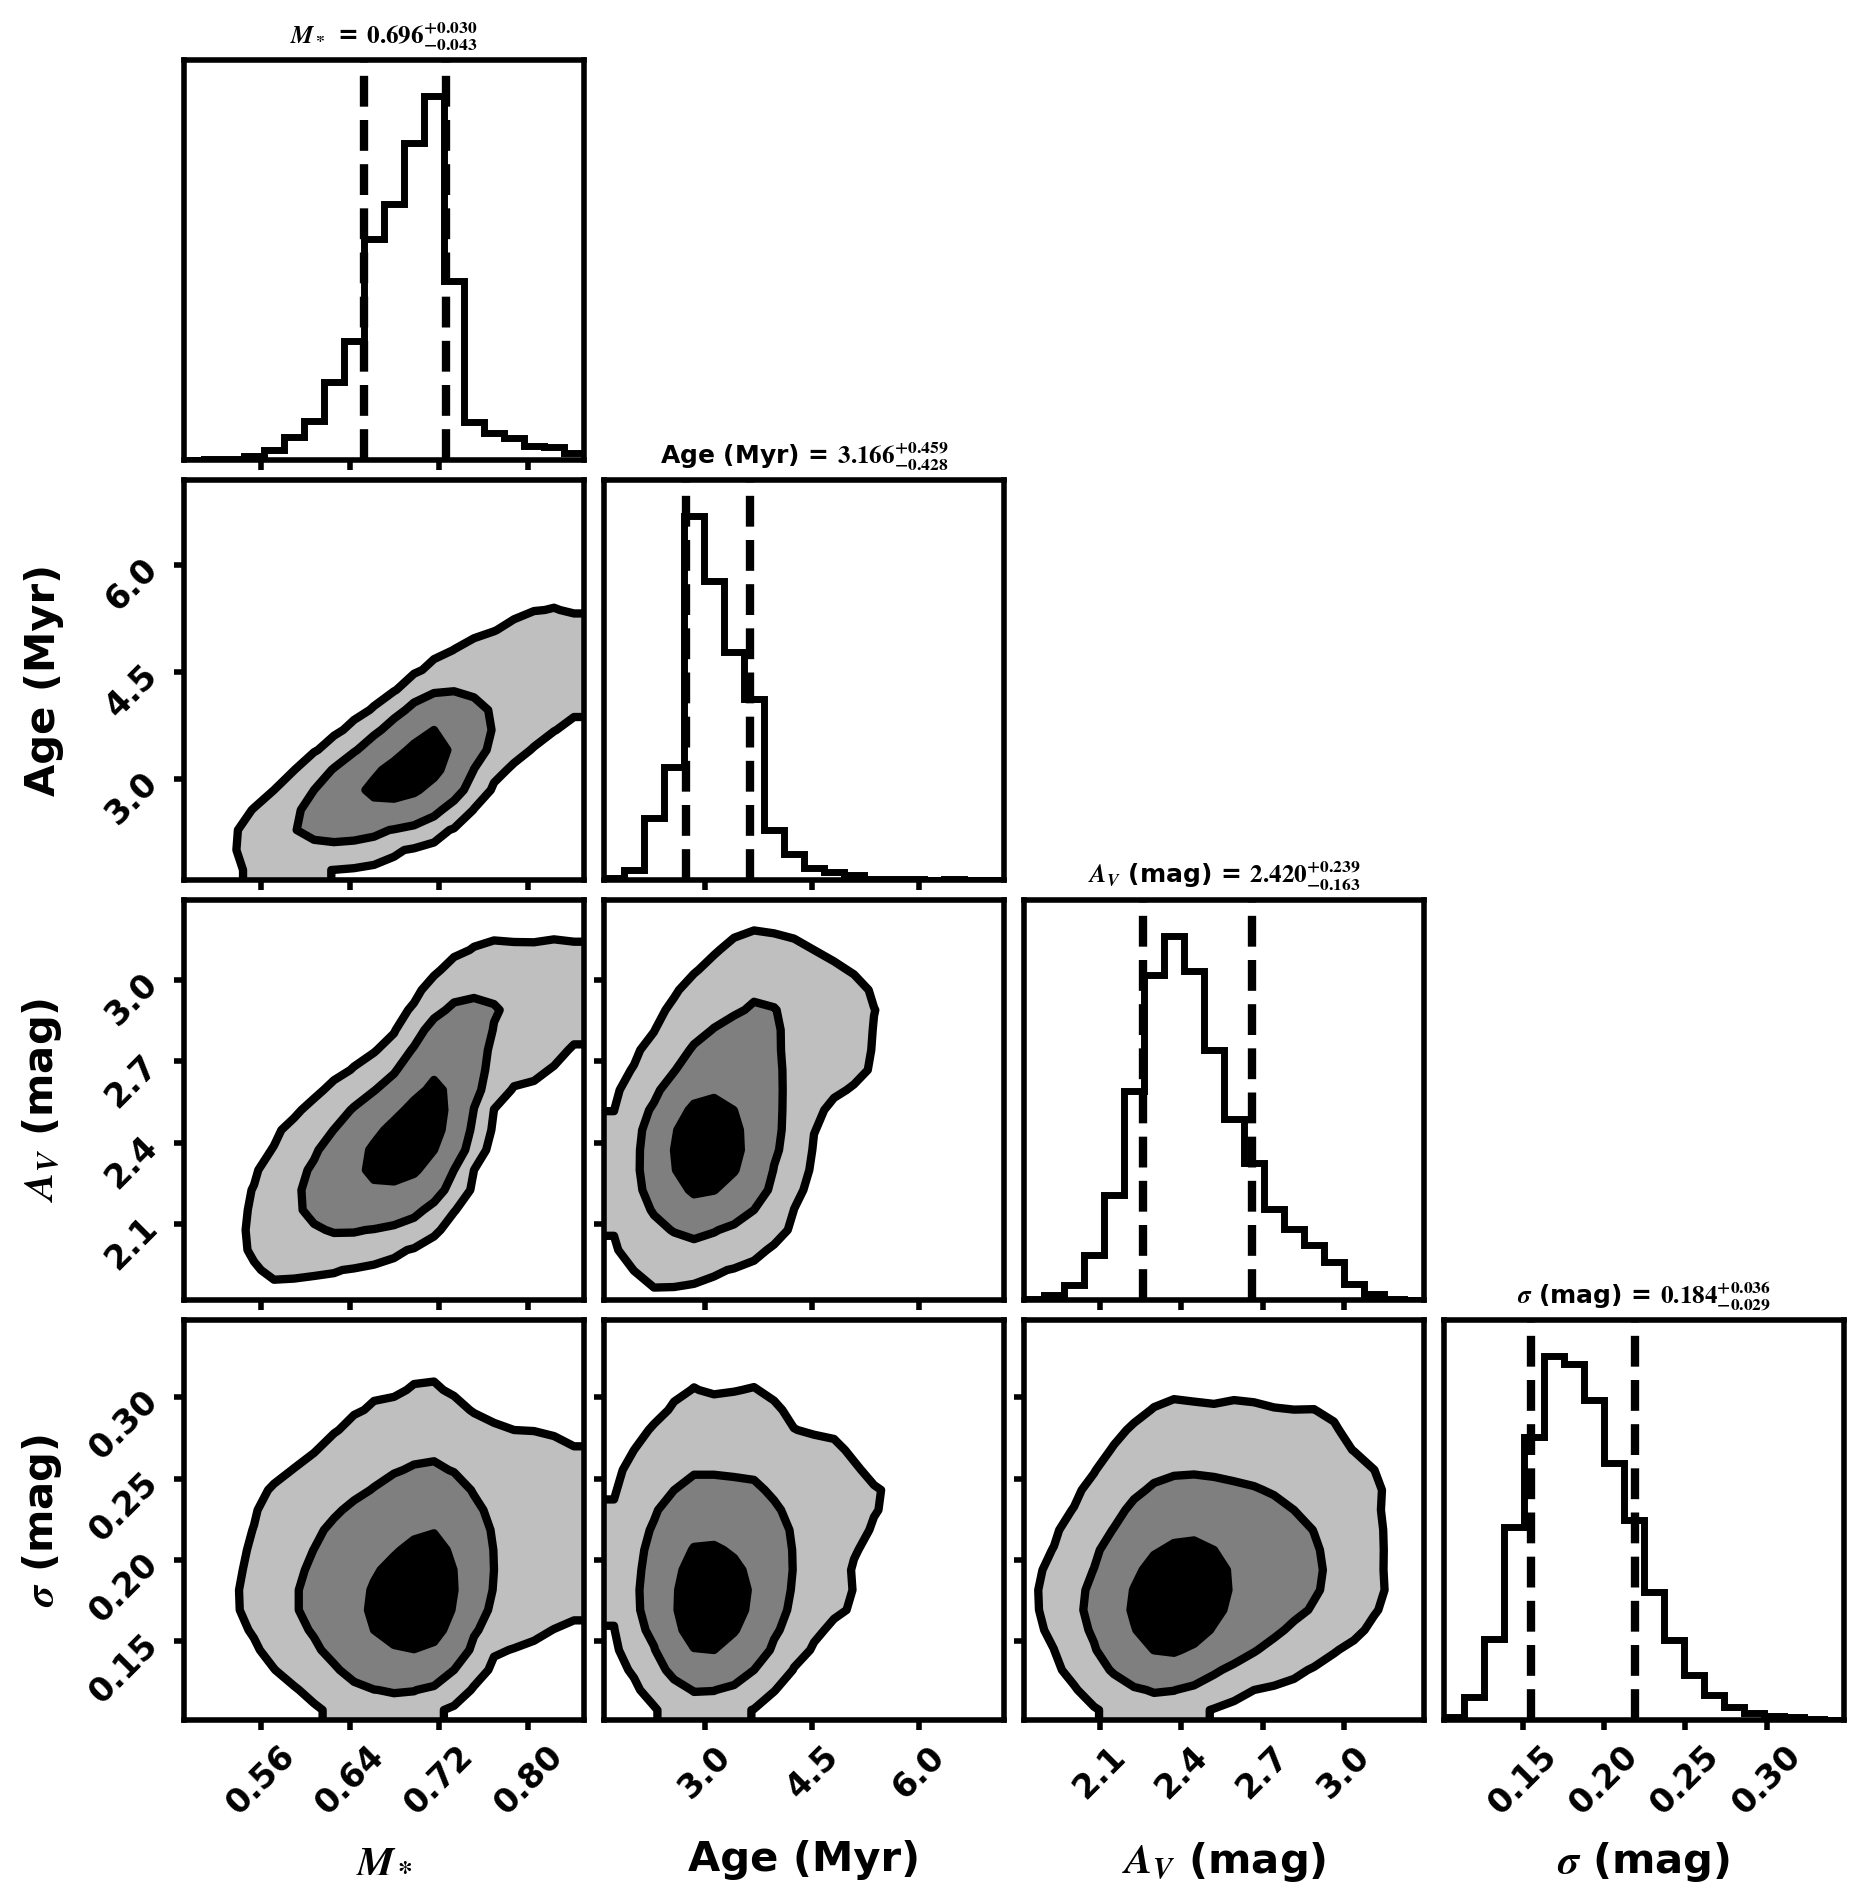

In [168]:
burn = sampler.iteration//2
samples = sampler.get_chain()
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = [r'$M_*$',r'Age (Myr)',r'$A_V$ (mag)',r'$\sigma$ (mag)']
for i in range(ndim):
     ax = axes[i]
     ax.plot(samples[:, :, i], "k", alpha=0.3)
     ax.set_xlim(0, len(samples))
     ax.set_ylabel(labels[i])
     ax.yaxis.set_label_coords(-0.1, 0.5)
        
fig.set_rasterized(True)
fig.show()

flat_samples = sampler.get_chain(discard=burn, thin=1, flat=True)

fig = corner.corner( 
    flat_samples,show_titles=True,labels=labels,quantiles=(0.16, 0.84),range=[0.9999,0.9999,0.9999,0.9999],
    fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 9},title_fmt='.3f',smooth=0.8,
    hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))]
);
fig.set_rasterized(True)
fig.savefig('Corner_primary.pdf',dpi=400)

## get the best-fit model
probs = sampler.get_log_prob(discard=burn, thin=1, flat=True)
l = np.squeeze(np.where(probs == np.max(probs)))
params = np.array(flat_samples[l,:])

mass,age,av,logf = params
model_mags,teff,logg = interpolate_mags(age,mass,models,returnparams=True,kind='cubic')
redmag = extinction.fm07(waves,av)
prediction = model_mags+redmag
r = np.sqrt(6.6743e-8*mass*1.989e33/10**logg)/6.955e10
print(10**teff,logg,r)
for i,j,k,l,m in zip(prediction,mags,names,mag_errs,model_mags):
    print(m,k,i,j,(i-j)/(np.sqrt(l**2+logf**2)))
    
    
elements = 1000

rads = []
teffs = []
for i in range(elements):
    index = random.randrange(0, np.size(flat_samples[:,0])-1)
    mass,age,av,missing_unc = flat_samples[index,:]
    
    model_mags,teff,logg = interpolate_mags(age,mass,models,returnparams=True,kind='cubic')
    redmag = extinction.fm07(waves,av)
    prediction = model_mags+redmag
    r = np.sqrt(6.6743e-8*mass*1.989e33/10**logg)/6.955e10
    teff = 10**teff
    teffs.append(teff)
    rads.append(r)
    
print(np.median(teffs),np.std(teffs),np.median(rads),np.std(rads))

In [161]:
l

array(10880)

In [ ]:
probs = sampler.get_log_prob(discard=burn, thin=1, flat=True)
l = np.squeeze(np.where(probs == np.max(probs)))[0]
params = np.array(flat_samples[l,:])
mass,age,av,logf = params


In [ ]:
nmonte = 10000
mass = np.random.normal(0.71,0.05,size=nmonte)
rad = np.random.normal(loc=1.48,scale=0.07,size=nmonte)
den = mass/rad**3
print(round(np.median(den),3),'+/-',round(np.std(den),3))

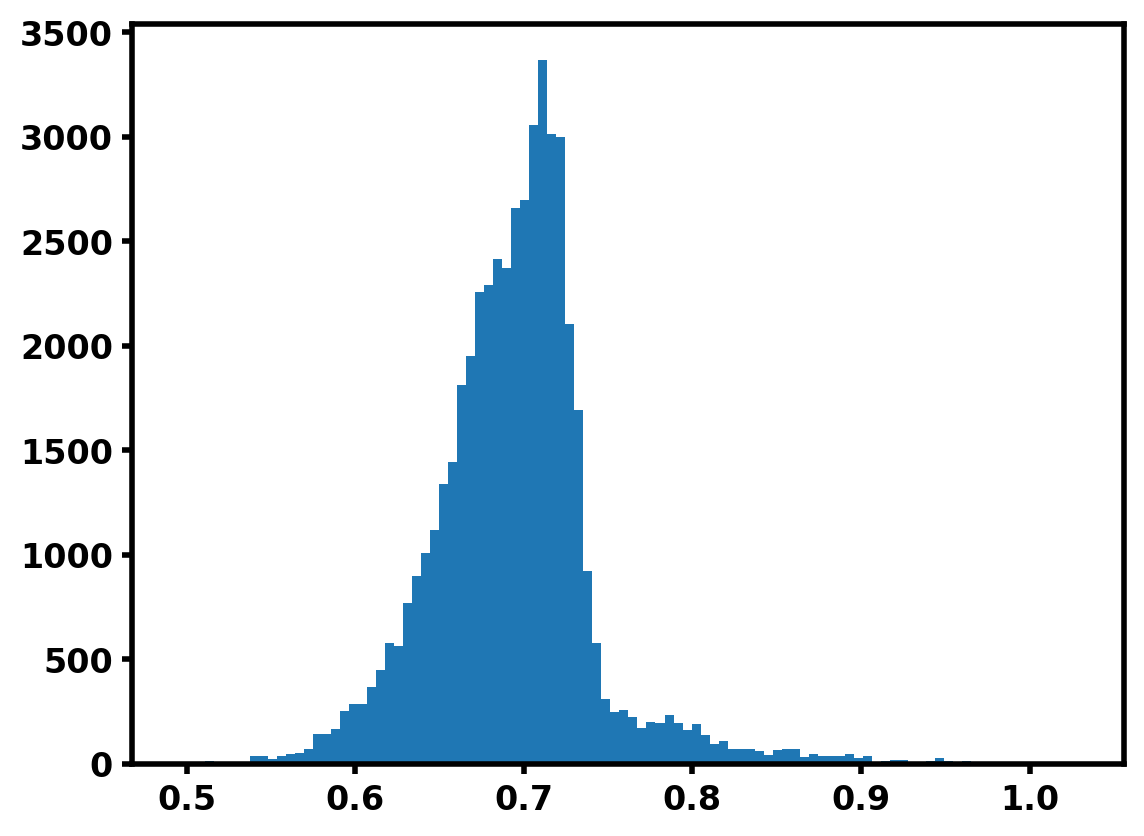

In [112]:
plt.hist(flat_samples[:,0],bins=100)
plt.show()

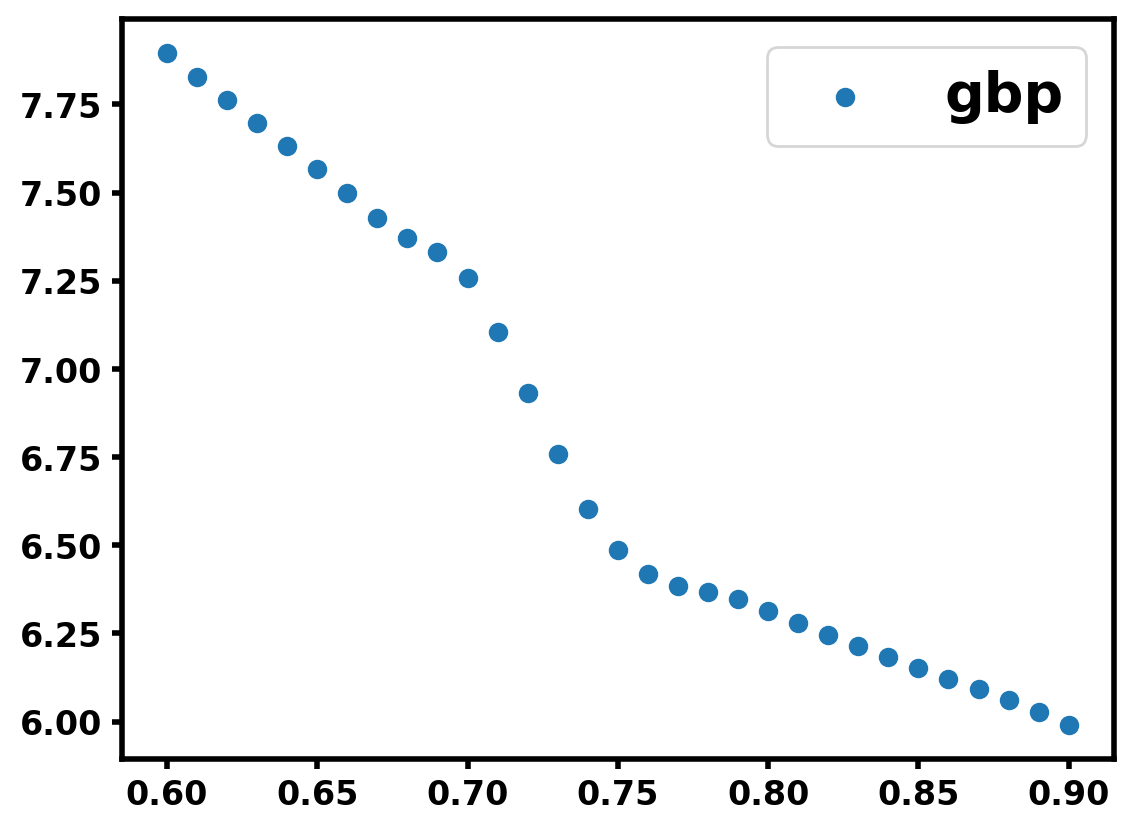

In [154]:
index = 0
mag = []
mas = []
for m in np.arange(0.6,0.9,0.01):
    model_mags,teff,logg = interpolate_mags(age,m
                                        ,models,returnparams=True,kind='cubic')
    mag.append(model_mags[index])
    mas.append(m)
    
plt.scatter(mas,mag,label=names[index])
plt.legend()
plt.show()

In [155]:
model_mags = interpolate_mags(params[1],params[0],models)
redmag = extinction.fm07(waves,params[2])
prediction = model_mags+redmag
for i,j,k,l in zip(prediction,mags,names,mag_errs):
    print(k,i,j,(i-j)/l)

gbp 9.913636597179202 9.573296566252726 8.726667459653251
grp 6.704555613974167 6.716696566252728 -0.5016922429157594
gaiag 8.48609769748424 7.959796566252726 16.550350038726847
jmag 4.589665092572755 4.687496566252727 -3.3734990924128243
hmag 3.579047472087623 3.7344965662527274 -5.181636472170152
kmag 3.2836388417488447 3.3544965662527266 -2.530633017995784
gp 10.639505481263807 10.786496566252726 -4.899702832963963
rp 8.480157826824227 8.638496566252726 -5.277957980949981
ip 7.132362886919683 7.626496566252727 -2.4706683966652188
w1 3.094037358660435 3.0164965662527274 3.524581473077609
w2 3.073220974653348 2.871496566252728 9.605924209553333
s1 3.0585486540116182 3.068496566252727 -0.33159707470362676
s2 3.0704404248679324 3.0384965662527277 1.0647952871734923
s3 3.0117415180942375 2.948496566252728 1.5811237960377422
s4 2.9395393612892624 3.028496566252728 -2.223930124086637
psg 10.406873689324144 10.537696566252727 -59.46494405844695
psr 8.500049110307957 8.518596566252729 -1.244